In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import segmentation_models_pytorch as smp
from utils import *

c:\Users\PC\anaconda3\envs\seg\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
merge_cropped_images(3456,3456,384,384,"c:/Users/PC/Desktop/Short_Data/Denoised/all_4096/test_crop385_s385","c:/Users/PC/Desktop/Short_Data/Denoised/all_4096/test")

In [5]:
DEVICE = "cuda"
model = smp.UnetPlusPlus(
        encoder_name="vgg19",
        encoder_weights="imagenet",
        activation="sigmoid",
    
    )
model.load_state_dict(torch.load("best_step_model.pth"))
model.to(DEVICE)

def unpad_image(padded_image, original_size):
    target_height, target_width = padded_image.shape[:2]
    original_height, original_width = original_size,original_size
    pad_height = target_height - original_height
    pad_width = target_width - original_width

  
    if pad_height > 0:
        padded_image = padded_image[:-pad_height, :]
    if pad_width > 0:
        padded_image = padded_image[:, :-pad_width]

    return padded_image
def pad_image(image, target_size, pad_value=0):
    height, width = image.shape[:2]
    target_height, target_width = target_size


    pad_height = target_height - (height % target_height)
    pad_width = target_width - (width % target_width)

   
    padded_image = np.pad(image, ((0, pad_height), (0, pad_width), (0, 0)), mode='constant', constant_values=pad_value)

    return padded_image
def patched_predict(img,model, window_size = 576, stride =288):
    
    img_pad = pad_image(img,(window_size,window_size),0)
  
    bound = (window_size - stride)//2
    #print(img.shape[0],img.shape[1],img.shape[2])
    fullsize_pred = np.zeros((img_pad.shape[0], img_pad.shape[1]))
    #tmp_arr = np.full((img.shape[0], img.shape[1]), channel-1)
    #fullsize_pred = y_pred=to_categorical(tmp_arr, num_classes=channel)

    row=(img_pad.shape[0] - 2*bound)//stride
    column=(img_pad.shape[1] - 2*bound)//stride
    #model_class = util.load_model('/home/vivente/Desktop/TEZ/Code/segmentation/out_classification/2021_November_27-15_57_51/fcn_trained_model')
    #model_class = 0
    
    for i in range(row):
        for j in range(column):
            #print(i,j)
            x_start = (i*stride)
            x_stop = x_start + window_size
            y_start = (j*stride)
            y_stop = y_start + window_size
            bx_start = x_start + bound
            bx_stop  = x_stop - bound
            by_start = y_start + bound
            by_stop  = y_stop - bound
            #print(x_start,x_stop,y_start,y_stop)
            #print(bx_start,bx_stop,by_start,by_stop)
            pred_in = img_pad[x_start:x_stop, y_start:y_stop,:]
            preprocessing_fn = smp.encoders.get_preprocessing_fn("vgg19","imagenet")
            sample = get_preprocessing(preprocessing_fn,0)(image=pred_in)
            pred_in = sample["image"]
            pred_in = torch.from_numpy(pred_in).to(DEVICE).unsqueeze(0)
            with torch.no_grad():
                part_pred = model.predict(pred_in).cpu().numpy().astype(np.float32)
    
            
            #part_pred_class = model_class.predict(np.reshape(pred_in, (1,window_size, window_size, 3)))
            #if(part_pred_class<0.5
            #if(y_patch.max()!=0):
            #    part_pred = model.predict(np.reshape(pred_in, (1,window_size, window_size, 3)))
            #else:
            #    part_pred = background_array
            part_pred = np.reshape(part_pred, (window_size, window_size))
            #print(np.shape(part_pred))
            ################ Koseler ###############
            if(i==0 and j== 0):                     #####baslangic kösesi
                valid_part = part_pred[0:window_size - bound, 0:window_size - bound]
                #print(np.shape(valid_part))
                fullsize_pred[0:bx_stop, 0:by_stop] = valid_part
            elif(i==0 and j== column-1):            #####sag kose
                valid_part = part_pred[0:window_size - bound, bound:window_size]
                #print(np.shape(valid_part))
                fullsize_pred[0:bx_stop, by_start:y_stop] = valid_part
            elif(i==row-1 and j==column-1):         ####sag alt kose
                valid_part = part_pred[bound:window_size, bound:window_size]
                #print(np.shape(valid_part))
                fullsize_pred[bx_start:x_stop, by_start:y_stop] = valid_part
            elif(i==row-1 and j==0):                ####sol alt kose
                valid_part = part_pred[bound:window_size, 0:window_size - bound]
                #print(np.shape(valid_part))
                fullsize_pred[bx_start:x_stop, y_start:by_stop] = valid_part
            ################ Kenarlar ##############
            elif(i==0 and j!=0 and j!= column-1):   #####ust kenar
                valid_part = part_pred[0:window_size - bound, bound:window_size - bound]
                #print(np.shape(valid_part))
                fullsize_pred[0:bx_stop, by_start:by_stop] = valid_part
            elif(j==0 and i!=0 and i!=row-1):       #####sol kenar
                valid_part = part_pred[bound:window_size - bound, 0:window_size - bound]
                #print(np.shape(valid_part))
                fullsize_pred[bx_start:bx_stop, 0:by_stop] = valid_part
            elif(i==row-1 and j!=column-1 and j!=0):####alt kenar
                valid_part = part_pred[bound:window_size, bound:window_size - bound]
                #print(np.shape(valid_part))
                fullsize_pred[bx_start:x_stop, by_start:by_stop] = valid_part
            elif(j==column-1 and i!=row-1 and i!=0):#####sag kenar
                valid_part = part_pred[bound:window_size - bound, bound:window_size]
                #print(np.shape(valid_part))
                fullsize_pred[bx_start:bx_stop, by_start:y_stop] = valid_part

            else:
                valid_part = part_pred[bound:window_size - bound, bound:window_size - bound]
                #print(np.shape(valid_part))
                fullsize_pred[bx_start:bx_stop, by_start:by_stop] = valid_part

        unpad_fullsize_pred = unpad_image(fullsize_pred,img.shape[1])

    '''
    print("Full size prediction completed")
    colour_img_pred = util.colorize_binary_img(fullsize_pred)
    plt.imshow(colour_img_pred)
    plt.show()
    '''

    return np.asarray(unpad_fullsize_pred)

In [46]:
img = cv2.imread("c:/Users/PC/Desktop/Short_Data/Original/test/IDRiD_70.png")
img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gt = cv2.imread("c:/Users/PC/Desktop/Short_Data/labels/test/IDRiD_70.png",cv2.IMREAD_GRAYSCALE)
gt = np.where(gt == 3,1,0)
a = patched_predict(img,model,384,192)

In [6]:
dir_img = "c:/Users/PC/Desktop/Short_Data/Denoised/all_4096/test"
dir_mask = "c:/Users/PC/Desktop/Short_Data/labels/test/"
imgs = natsorted(os.listdir(dir_img))
masks = [file for file in natsorted(os.listdir(dir_mask)) if file.lower().endswith(".png")]

In [7]:
total_auc_pr = 0
for img, mask in zip(imgs, masks):
    img = cv2.imread(f"{dir_img}/{img}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    gt = cv2.imread(f"{dir_mask}/{mask}", cv2.IMREAD_GRAYSCALE)
    gt = np.where(gt == 3, 1, 0)
    
    a = patched_predict(img, model, 384, 192)
    
    auc_pr = calculate_auc_pr(gt, a)
    print(auc_pr)
    total_auc_pr += auc_pr

average_auc_pr = total_auc_pr / len(imgs)
print(f"Average AUC-PR: {average_auc_pr}")

0.5221160435935369
0.3865593968107336
0.2450918962343069
0.399892076472226
0.5636194432461155
0.5145801177126483
0.33200653395805235
0.43046757992699025
0.17903923979662217
0.5671291538584791
0.4939010750016446
0.5117372853796518
0.5535995577748445
0.2247010345030402
0.39195369708608285
0.3369751763830536
0.4210289034533834
0.5089619048109694
0.4746420857072725
0.4738304365827869
0.5515793741396607
0.561084703286008
0.5083019317361156
0.5476533943337758
0.4532640939221185
0.5030988578130634
0.3147051749692096
Average AUC-PR: 0.44338963587008856


In [47]:
test_mask = np.load("out/2023_December_12-19_06_40/merged_pred_probs_ma/merged_IDRiD_70.png_1.png_probs.npy")

In [49]:
calculate_auc_pr(gt,test_mask)

0.31606480139455456

0.00047211448
0.00047211448
0.00047211448
0.00047211448
0.00047211448
0.00047211448
0.00047211448
0.00047211448
0.00047211448
0.00047211468
0.00047210953
0.00050081324
0.00047211448
0.0004722272
0.000472596
0.00047211448
0.00047211448
0.00047211448
0.00047211448
0.00047211448
0.00047211448
0.00047211448
0.00047212167
0.00047211448
0.0004721108
0.00047211855
0.00047211448
0.00047212568
0.0004722459
0.00047204923
0.00047211448
0.00047211448
0.00047095752
0.00047211468
0.00047211448
0.00093971874
0.00047211448
0.00047220243
0.00047217993
0.00047257528
0.00047246137
0.00047211561
0.00047211448
0.00047211448
0.00047211448
0.00047211448
0.00047237446
0.00047209466
0.00047511488
0.00047211448
0.0004704967
0.00047287153
0.00047212437
0.00047211448
0.00047211448
0.00047211448
0.00047210953
0.00047376644
0.00047213025
0.0004721066
0.0005315018
0.00047209286
0.00047211448
0.00047211448
0.00047211448
0.00047208497
0.00047209646
0.00047043886


KeyboardInterrupt: 

In [ ]:
gt = cv2.imread("IDRiD_79w.png",cv2.IMREAD_GRAYSCALE)
gt_2752 = cv2.imread("IDRiD_79_2752.png",cv2.IMREAD_GRAYSCALE)
gt_2752 =np.where(gt_2752  == 3,1,0)
gt = np.where(gt == 3,1,0)
original_result = cv2.imread("merged_IDRiD_79.png_1.png.png",cv2.IMREAD_GRAYSCALE)

original_result.shape

In [94]:
cv2.imwrite("strie_pred.png",a)

True

In [95]:
cv2.imwrite("normal_pred.png",original_result)

True

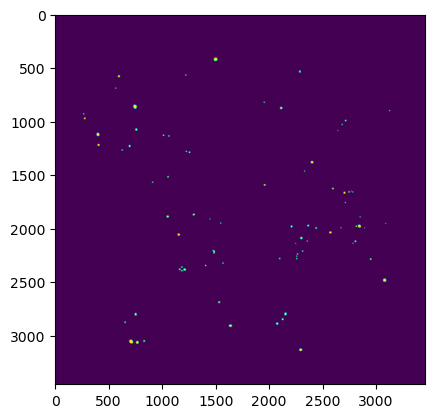

In [69]:
plt.imshow(gt)

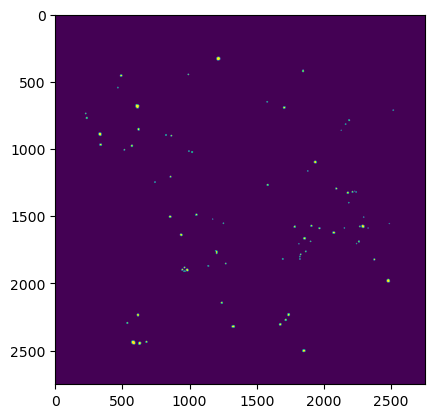

In [70]:
plt.imshow(gt_2752)

In [71]:
calculate_auc_pr(gt_2752,original_result)

0.44436424328782576

In [80]:
a.shape

(3456, 3456)

In [84]:
gt.shape

(3456, 3456)

In [88]:
calculate_auc_pr(gt,a)

ValueError: multiclass format is not supported